In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma

In [2]:
project = sg.get_project()

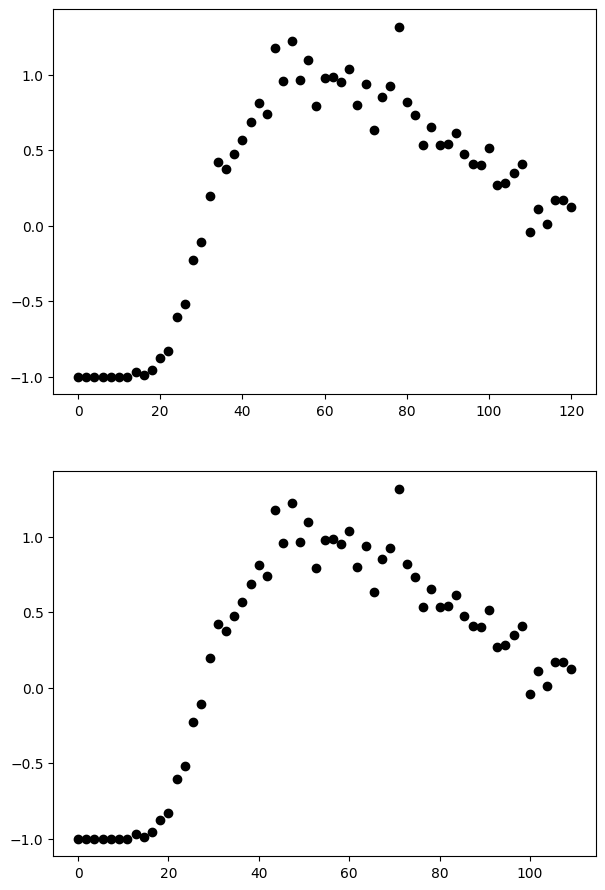

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
c = 1.42
# for job in project.find_jobs({'fire_prob': 0.17}):
for job in project:
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.weibull_b, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = job.sp.weibull_b * gamma(1+1/c)
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

(0.0, 20.0)

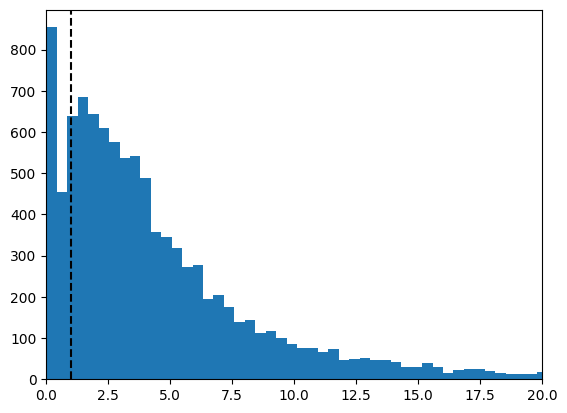

In [82]:
plt.hist(final_approx_vec/init, bins=400);
plt.axvline(1, ls='--', c='k')
plt.xlim(0,20)

In [9]:
for job in project.find_jobs({'weibull_b': 44}):
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        y_vec = final_approx_vec
        census_t = np.array(data['census_t'])

(-480.0, 24000.0)

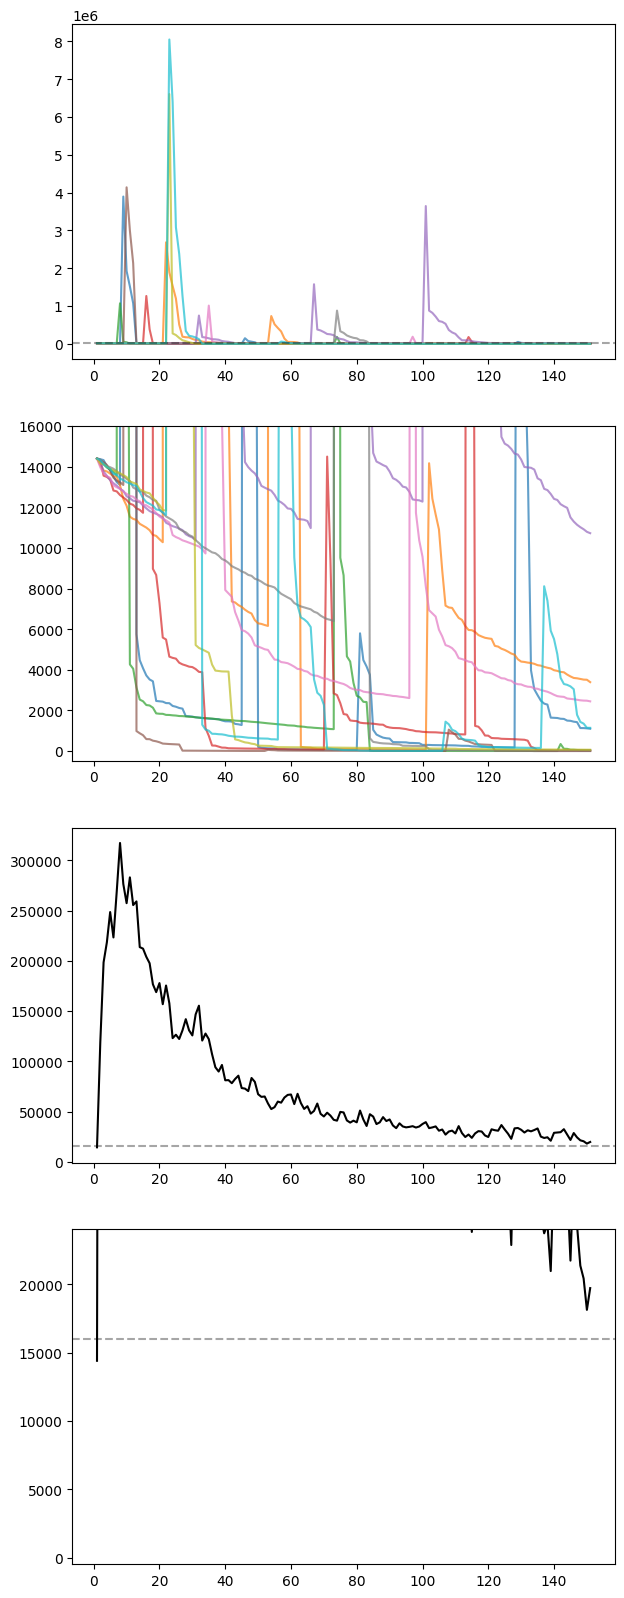

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))
for N in N_tot_vec[::int(len(N_tot_vec)/10)]:
    axs[0].plot(census_t,N, alpha=0.7)
    axs[1].plot(census_t,N, alpha=0.7)
K_adult = 16000
axs[0].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[1].set_ylim(-0.03*K_adult,K_adult)
#print(len(model.N_tot_vec.mean(axis=0)))
axs[2].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[2].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[3].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].set_ylim(-0.03*K_adult,1.5*K_adult)

(-100.0, 5000.0)

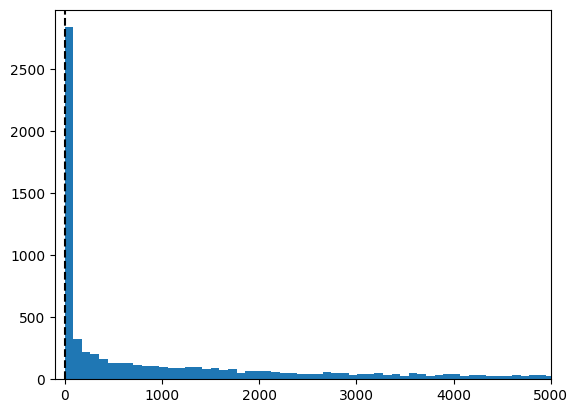

In [114]:
hist = plt.hist(y_vec, bins=10000);
# hist = plt.hist(y_vec, bins=100);
plt.axvline(0, ls='--', c='k')
plt.xlim(-100,5000)